In [37]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
from typing import List
import pandas as pd
import numpy as np
from gensim.models import FastText,fasttext
from tqdm import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [2]:
dataset = pd.read_csv('./data/cleanedCorpus.csv')
dataset

,qc,sp
0,ch'arwi,desorden
1,runa,persona
2,chanin,precio
3,puka,rojo
4,hallp'a,tierra
...,...,...
2064,runakuna manan mallkikunata tarpunkuchu chaymi...,la personas no plantan árboles es uno de los f...
2065,erqe mamanpa wañusqanmanta waqan,el niño llora porque su madre murió
2066,huk wayna chakamanta wukchuyukusqa hinaspa wañ...,un joven se lanzó del puentemurió
2067,mama churin mana wasinman kutimusqanmanta waqan,la madre llora porque su hijo no vuelvela casa


In [3]:
SRC_LANGUAGE = 'sp'
TGT_LANGUAGE = 'qc'

# Place-holders
embeed_transform = np.array([])
vocab_transform = {}

In [6]:
qc_embeding_path = './embeddings/lematized_embedding_v1.model'
qc_embeddings_model = FastText.load(qc_embeding_path)

In [4]:
es_embeding_path = './embeddings/cc.es.300.bin'
es_embeddings_model = fasttext.load_facebook_vectors(es_embeding_path)

In [7]:
vocab_sp = {'<unk>': 0, '<pad>': 1, '<bos>': 2, '<eos>': 3}
vocab_qc = {'<unk>': 0, '<pad>': 1, '<bos>': 2, '<eos>': 3}

embed_sp = {'<unk>': np.random.rand(300), '<pad>': np.random.rand(300), '<bos>': np.random.rand(300), '<eos>': np.random.rand(300)}
embed_qc = {'<unk>': np.random.rand(50), '<pad>': np.random.rand(50), '<bos>': np.random.rand(50), '<eos>': np.random.rand(50)}


# for sent in es_embeddings_model.key_to_index:
#     for word in sent.split():
#         if word not in vocab_sp:
#             vocab_sp[word] = len(vocab_sp)
#             embed_sp[word] = es_embeddings_model[word]

# for sent in qc_embeddings_model.wv.key_to_index:
#     for word in sent.split():
#         if word not in vocab_qc:
#             vocab_qc[word] = len(vocab_qc)
#             embed_qc[word] = qc_embeddings_model.wv[word]

for sent in dataset['sp']:
    for word in sent.split():
        if word not in vocab_sp:
            vocab_sp[word] = len(vocab_sp)
            embed_sp[word] = es_embeddings_model[word]

for sent in dataset['qc']:
    for word in sent.split():
        if word not in vocab_qc:
            vocab_qc[word] = len(vocab_qc)
            embed_qc[word] = qc_embeddings_model.wv[word]            

def build_vocab(ln):
    def transform_token(txt_input):
        tokens = []
        for token in txt_input.split():
            if ln == SRC_LANGUAGE:
                if token in vocab_sp:
                    tokens.append(vocab_sp[token])
                else:
                    similar_token = es_embeddings_model.most_similar(token)[0][0]
                    if similar_token in vocab_sp:
                        tokens.append(vocab_sp[similar_token])
                    else:
                        tokens.append(vocab_sp['<unk>'])  # Fallback to <unk> if similar token is also not in vocab
            else:
                tokens.append(vocab_qc[token] if token in vocab_qc else vocab_qc['<unk>'])  # Fallback to <unk> for qc
        return tokens
    return transform_token

In [8]:
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln] = build_vocab(ln)

In [9]:
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']


In [10]:
# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size,ln:str):
        super(TokenEmbedding, self).__init__()
        if ln == SRC_LANGUAGE:
            embeddings = torch.from_numpy(np.array([embed_sp[word] for word in vocab_sp.keys()])).float()
            self.embedding = nn.Sequential( nn.Embedding.from_pretrained(embeddings, padding_idx=PAD_IDX,freeze=False),
                                           nn.Linear(300,emb_size))
        else:
            embeddings = torch.from_numpy(np.array([embed_qc[word] for word in vocab_qc.keys()])).float()
            self.embedding = nn.Embedding.from_pretrained(embeddings, padding_idx=PAD_IDX,freeze=False)
        self.emb_size = emb_size
        self.ln = ln

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size,SRC_LANGUAGE)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size,TGT_LANGUAGE)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [11]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [29]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_sp)
TGT_VOCAB_SIZE = len(vocab_qc)
EMB_SIZE = 50
NHEAD = 5
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

# for p in transformer.parameters():
#     if p.dim() > 1:
#         nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/home/fabzio/.conda/envs/tacc/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [13]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [14]:
from torch.utils.data import Dataset

# Dataset class for DataLoader
class LanguageDataset(Dataset):
    def __init__(self, src_list, tgt_list):
        self.src_list = src_list
        self.tgt_list = tgt_list
        assert (len(self.src_list) == len(self.tgt_list))

    def __len__(self):
        return len(self.src_list)

    def __getitem__(self, key):
        return [self.src_list[key], self.tgt_list[key]]

In [15]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = LanguageDataset(dataset[SRC_LANGUAGE], dataset[TGT_LANGUAGE])
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

In [39]:
from timeit import default_timer as timer
NUM_EPOCHS = 700

history_loss = []

for epoch in tqdm(range(1, NUM_EPOCHS+1)):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    history_loss.append(train_loss)
    #val_loss = evaluate(transformer)
    #print((f"Epoch: {epoch}, Train loss: {train_loss:.3f})", f"Epoch time = {(end_time - start_time):.3f}s")) #, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

100%|██████████| 700/700 [03:38<00:00,  3.21it/s]


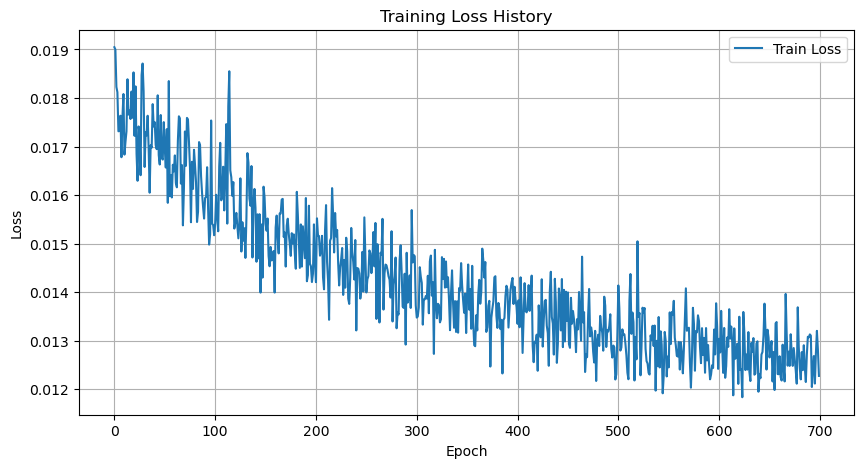

In [40]:
import matplotlib.pyplot as plt

# Plotting the loss history
plt.figure(figsize=(10, 5))
plt.plot(history_loss, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.grid(True)
plt.show()


In [32]:

# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


vocab_qc_inv = {v: k for k, v in vocab_qc.items()}
# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    tokenized_sentence =  list(tgt_tokens.cpu().numpy())
    sentence = ' '.join(vocab_qc_inv[i] for i in tokenized_sentence)
    return sentence.replace('<bos>', '').replace('<eos>', '')
    

In [41]:
translate(transformer, "buenas")

' mamayqa '

In [45]:
scripted_model = torch.jit.script(transformer)
scripted_model.save("transformer_translator_sp_qc.pt")


/home/fabzio/.conda/envs/tacc/lib/python3.12/site-packages/torch/jit/_recursive.py:314: UserWarning: 'norm' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  warnings.warn(
